In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import pickle
import os

Our goal is to check last black friday sale and analyse it
1) Our marketing department wants to know what product category purchase rate is the highest and also what product category is giving our company the highest amount of income.
2) Do some sellers increase their prices before black friday to have "fake discount"? That sellers should be banned from participating in next black friday events
3) What categories of products were sold the most by state and city - we need to be sure that we have enough goods for our customers

Having this 3 objectives here is the list of steps that we need to do
1) import all related datasets
2) check all the types of imported columns
3) check all the columns for missing values
4) check for anomalies
5) rename-translate-transform data, create one big table, prepare it for analysis
6) answer the questions

Step 6 will be discussed later in details

# Import all related datasets

We need 4 tables here
1) data/input/olist_orders_dataset.csv - here we have order_id, order_status and order_purchase_timestamp
2) data/input/olist_order_items_dataset.csv - here we have order_id, product_id, seller_id and price per item
3) data/input/olist_products_dataset.csv - here we have product_id and product_category_name
4) data/input/olist_sellers_dataset.csv - here we have seller_id, seller_city and seller_state

In [2]:
orders_file_path = '../data/input/olist_orders_dataset.csv'
order_items_file_path = '../data/input/olist_order_items_dataset.csv'
products_file_path = '../data/input/olist_products_dataset.csv'
sellers_file_path = '../data/input/olist_sellers_dataset.csv'

orders_col_list = ['order_id', 'order_status', 'order_purchase_timestamp']
order_items_col_list = ['order_id', 'product_id', 'seller_id', 'price']
products_col_list = ['product_id', 'product_category_name']
sellers_col_list = ['seller_id', 'seller_city', 'seller_state']

# TODO prints will be logs in .py programm
def get_filename_from_filepath(filepath):
    # TODO add another checks - windows \ path, case when file in the same dir, etc.
    position_of_last_slash = filepath.rfind('/')
    filename = filepath[position_of_last_slash + 1:]
    return filename

def import_and_check_dataframe(filepath: str, col_list):
    # TODO add different imports for different filetypes
    filename = get_filename_from_filepath(filepath)
    # TODO add try exept here
    df = pd.read_csv(filepath, usecols=col_list)

    if ~df.empty:
        print(filename + ' imported sucsessfully! Shape is', df.shape)
    else:
        print('Empty dataframe! Check file')

    return df

df_orders = import_and_check_dataframe(orders_file_path, orders_col_list)
df_order_items = import_and_check_dataframe(order_items_file_path, order_items_col_list)
df_products = import_and_check_dataframe(products_file_path, products_col_list)
df_sellers = import_and_check_dataframe(sellers_file_path, sellers_col_list)

all_dataframes_with_names = [['orders_dataset', df_orders], 
                             ['order_items', df_order_items], 
                             ['products', df_products],
                             ['sellers', df_sellers]]

olist_orders_dataset.csv imported sucsessfully! Shape is (99441, 3)
olist_order_items_dataset.csv imported sucsessfully! Shape is (112650, 4)
olist_products_dataset.csv imported sucsessfully! Shape is (32951, 2)
olist_sellers_dataset.csv imported sucsessfully! Shape is (3095, 3)


# Check all the types of imported columns
# Plus missing values

In [3]:
def show_info_on_df(name_df_pair):
    name = name_df_pair[0]
    df = name_df_pair[1]
    print('-' * 40)
    print('general information on', name, 'df')
    print('-' * 40)
    print('non missing values and dtypes')
    print(df.info())
    print('-' * 40)
    print('only missing values')
    print(df.isnull().sum())

    print('-' * 40)


for pair in all_dataframes_with_names:
    show_info_on_df(pair)


----------------------------------------
general information on orders_dataset df
----------------------------------------
non missing values and dtypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  99441 non-null  object
 1   order_status              99441 non-null  object
 2   order_purchase_timestamp  99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
None
----------------------------------------
only missing values
order_id                    0
order_status                0
order_purchase_timestamp    0
dtype: int64
----------------------------------------
----------------------------------------
general information on order_items df
----------------------------------------
non missing values and dtypes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 t

order_purchase_timestamp column in df_orders imported as object. We need to transform it to datetime format

We have 610 products with missing category. This is less than 2% of all products.<br>
In most cases it is reasonable to drop this data, but let's be extra safe here and be sure that this products sell rate is low (we will check it later)

In [4]:
# TODO we can create a function here. But for now it is only one column
# TODO add possible format scheme for parsing timestamp like "dd-mm-yyy HH:MM:SS"
# transform order_purchase_timestamp to datetime
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
print(df_orders.info())
print('-' * 80)

# testing that everything worked just fine
timestamp_test_obj = df_orders['order_purchase_timestamp'].iloc[0]

try:
    print(timestamp_test_obj, 
        "\nyear\t", timestamp_test_obj.year, 
        "\nmonth\t", timestamp_test_obj.month, 
        "\nday\t", timestamp_test_obj.day, 
        "\nhour\t", timestamp_test_obj.hour)
    print('everything is ok')
except Exception as e:
    print(f'something is wrong, check error: \n{e}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   order_status              99441 non-null  object        
 2   order_purchase_timestamp  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 2.3+ MB
None
--------------------------------------------------------------------------------
2017-10-02 10:56:33 
year	 2017 
month	 10 
day	 2 
hour	 10
everything is ok


# Check anomalies

In [5]:
def calculate_statistic_info(name_df_pair):
    name = name_df_pair[0]
    df = name_df_pair[1]
    print('-' * 40)
    print(f'general stat information on {name} df')
    print('-' * 40)
    print(df.describe())
    print('-' * 40)


for pair in all_dataframes_with_names:
    calculate_statistic_info(pair)


----------------------------------------
general stat information on orders_dataset df
----------------------------------------
                                order_id order_status order_purchase_timestamp
count                              99441        99441                    99441
unique                             99441            8                    98875
top     e481f51cbdc54678b7cc49136f2d6af7    delivered      2018-04-11 10:48:14
freq                                   1        96478                        3
first                                NaN          NaN      2016-09-04 21:15:19
last                                 NaN          NaN      2018-10-17 17:30:18
----------------------------------------
----------------------------------------
general stat information on order_items df
----------------------------------------
               price
count  112650.000000
mean      120.653739
std       183.633928
min         0.850000
25%        39.900000
50%        74.990000
75%   

/tmp/ipykernel_832/3683524780.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe())


Looks like no anomalies here. Some prices could be really high and 6735$ for single item is something imaginable.
Also we have data recorded for 2 years - so no 1900 year anomalies or something.
Also it seems that logging of time is pretty precise because one of the most frequent value is 2018-04-11 10:48:14 and its only appears 3 times (and it is black friday) - so no delays or something in logging order_purchase_timestamp

# Create one big table

In [6]:
# TODO here we can create function to check if our merges create duplicates - first thought: shape should remain the same

print(df_order_items.shape)
df_orders_plus = pd.merge(df_order_items, df_orders, on='order_id')
df_orders_plus = df_orders_plus.merge(df_products, on='product_id')
df_orders_plus = df_orders_plus.merge(df_sellers, on='seller_id')
print(df_orders_plus.shape)

# TODO remove this part, it is only for DEBUG and educational purposes
# ------------------8<-----------------------
# I'm just curious, let's check id's of this DataFrames objects. I bet df_orders_plus is in another memory cell
print('-'*40)
print(id(df_order_items))
print(id(df_orders))
print(id(df_products))
print(id(df_orders_plus))

# Nice =)
# ------------------8<-----------------------

(112650, 4)
(112650, 9)
----------------------------------------
139898748636944
139899549709792
139898748637184
139898748386848


In [7]:
np.float64(df_products.product_category_name.isnull().sum() * 100 / df_products.shape[0]).round(2)

1.85

In [8]:
# Now we can check our products with missing categories
sum_of_all_sold_products = df_orders_plus.price.sum()
mask_for_purch_wo_category = df_orders_plus['product_category_name'].isnull()

purch_wo_category_part_from_overall_purch_sum = df_orders_plus[mask_for_purch_wo_category].price.sum() / \
                                                sum_of_all_sold_products

count_of_all_sold_products = df_orders_plus.shape[0]
purch_wo_category_part_from_overall_purch_count = df_orders_plus[mask_for_purch_wo_category].shape[0] / \
                                                  count_of_all_sold_products

print('let\'s count how many products presented in db has no category',
      np.float64(df_products.product_category_name.isnull().sum() * 100 / df_products.shape[0]).round(2),
      '\nsum purch w/o category to all prch sum percent',     
      (purch_wo_category_part_from_overall_purch_sum*100).round(2),
      '\ncount purch w/o category to all prch count percent',
      np.float64(purch_wo_category_part_from_overall_purch_count*100).round(2))

let's count how many products presented in db has no category 1.85 
sum purch w/o category to all prch sum percent 1.32 
count purch w/o category to all prch count percent 1.42


This simple analysis tels us that even there is 1.85% of not products w/o category in our df_products dataset we can clearly see that sum and count of this products selling is more than 1%<br>
We also don't have product names in our dataset. Only categories.<br>
In real case scenario I would definitely consult with someone, who collected data or with business owner, but here I won't drop this data but I will assign "unknown category" label to it.

In [9]:
df_orders_plus['product_category_name'] = df_orders_plus['product_category_name'].fillna('unknown_category')
# I have used "unknown_category" with underscore here. Every category here is using this underscore

In [10]:
df_orders_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  112650 non-null  object        
 1   product_id                112650 non-null  object        
 2   seller_id                 112650 non-null  object        
 3   price                     112650 non-null  float64       
 4   order_status              112650 non-null  object        
 5   order_purchase_timestamp  112650 non-null  datetime64[ns]
 6   product_category_name     112650 non-null  object        
 7   seller_city               112650 non-null  object        
 8   seller_state              112650 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 8.6+ MB


# Rename-translate-transform data

In [11]:
df_orders_plus.product_category_name.value_counts()
# categories are in foreign language and merged together, let's try to fix it


cama_mesa_banho                  11115
beleza_saude                      9670
esporte_lazer                     8641
moveis_decoracao                  8334
informatica_acessorios            7827
                                 ...  
la_cuisine                          14
cds_dvds_musicais                   14
pc_gamer                             9
fashion_roupa_infanto_juvenil        8
seguros_e_servicos                   2
Name: product_category_name, Length: 74, dtype: int64

In [12]:


url = "https://google-translate1.p.rapidapi.com/language/translate/v2/languages"

headers = {
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers)

print(response.text)

{"data":{"languages":[{"language":"af"},{"language":"ak"},{"language":"am"},{"language":"ar"},{"language":"as"},{"language":"ay"},{"language":"az"},{"language":"be"},{"language":"bg"},{"language":"bho"},{"language":"bm"},{"language":"bn"},{"language":"bs"},{"language":"ca"},{"language":"ceb"},{"language":"ckb"},{"language":"co"},{"language":"cs"},{"language":"cy"},{"language":"da"},{"language":"de"},{"language":"doi"},{"language":"dv"},{"language":"ee"},{"language":"el"},{"language":"en"},{"language":"eo"},{"language":"es"},{"language":"et"},{"language":"eu"},{"language":"fa"},{"language":"fi"},{"language":"fr"},{"language":"fy"},{"language":"ga"},{"language":"gd"},{"language":"gl"},{"language":"gn"},{"language":"gom"},{"language":"gu"},{"language":"ha"},{"language":"haw"},{"language":"he"},{"language":"hi"},{"language":"hmn"},{"language":"hr"},{"language":"ht"},{"language":"hu"},{"language":"hy"},{"language":"id"},{"language":"ig"},{"language":"ilo"},{"language":"is"},{"language":"it"

In [13]:
url = "https://google-translate1.p.rapidapi.com/language/translate/v2"

payload = "q=Hello%2C%20world!&target=es&source=en"
headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("POST", url, data=payload, headers=headers)

print(response.text)

{"data":{"translations":[{"translatedText":"¡Hola Mundo!"}]}}


ok, we have this google translate API via rapidapi.com. We can do 5 requests per second and no more 500 requests per month. So, we have like 495 requests more to finish this translation<br>
Last .value_counts() operation showed us, that we have only 74 unique categories, so we can try to create multiple dicts with translations for categories<br>
Then we need to serialize this python object to have it in file for next usages (again, we have only 500 requests per month, 5 requests per second)

In [14]:
# let's try our value
def create_payload_from_value(value, target='en', source='pt'):
    payload = "q="
    payload += value
    payload += f'&target={target}&source={source}'
    return payload

create_payload_from_value(df_orders_plus.product_category_name.unique()[2])

'q=pet_shop&target=en&source=pt'

In [15]:
df_orders_plus.product_category_name.unique()[4]

'moveis_decoracao'

In [16]:
url = "https://google-translate1.p.rapidapi.com/language/translate/v2"

payload = create_payload_from_value(df_orders_plus.product_category_name.unique()[2])
headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
}

response = requests.request("POST", url, data=payload, headers=headers)

print(response.text)

{"data":{"translations":[{"translatedText":"pet Shop"}]}}


Looks like it worked. Let's try to create our first dict<br>
but I will save it with "if False:" just to be sure that this part is not executing automaticly

In [17]:
def translate_from_pt_to_en(str_to_translate):
    url = "https://google-translate1.p.rapidapi.com/language/translate/v2"
    headers = {
	"content-type": "application/x-www-form-urlencoded",
	"Accept-Encoding": "application/gzip",
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "google-translate1.p.rapidapi.com"
    }
    payload = create_payload_from_value(str_to_translate)
    
    responce = requests.request("POST", url, data=payload, headers=headers)
    try:
        parsed_translation = json.loads(responce.text)['data']['translations'][0]['translatedText']
    except Exception as e:
        print(f'something is wrong with {responce.text} translation, check error: \n{e}')
        parsed_translation = 'translation_error'


    return parsed_translation


In [18]:
a = translate_from_pt_to_en('ferramentas_jardim')

In [19]:
print(a)
time.sleep(0.21)
print(a)

garden_tools
garden_tools


In [20]:
def translate_series_of_values(series_of_values: pd.Series):
    translation = {}
    # used [:5] here just for debug perpuses
    for element in series_of_values.unique():
        translation[element] = translate_from_pt_to_en(element)
        # we need to sleep here because our max requests is 5 per second
        time.sleep(0.21)
    
    return translation

That was 500 CHARACTERS per month. OoOoOooU. Well, that's bad. Let's try another API?

In [21]:
url = "https://translated-mymemory---translation-memory.p.rapidapi.com/api/get"

querystring = {"langpair":"pt|en","q":"ferramentas_jardim","mt":"1","onlyprivate":"0","de":"a@b.c"}

# I know that sharing API keys is bad but this is free API use and I need this only for this project
headers = {
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "translated-mymemory---translation-memory.p.rapidapi.com"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

{"responseData":{"translatedText":"garden_tools","match":0.85},"quotaFinished":false,"mtLangSupported":null,"responseDetails":"","responseStatus":200,"responderId":"228","exception_code":null,"matches":[{"id":0,"segment":"ferramentas_jardim","translation":"garden_tools","source":"pt-PT","target":"en-GB","quality":70,"reference":"Machine Translation.","usage-count":2,"subject":false,"created-by":"MT!","last-updated-by":"MT!","create-date":"2022-10-24 05:46:13","last-update-date":"2022-10-24 05:46:13","match":0.85,"model":null}]}


Ok, looks like it works. And this API has 10 000 words / month limit which is great. Let's rewrite translate function

In [22]:
def create_querystring_from_value(value, target='en', source='pt'):
    # querystring_example = {"langpair":"pt|en",
    #                         "q":"ferramentas_jardim",
    #                         "mt":"1",
    #                         "onlyprivate":"0",
    #                         "de":"a@b.c"}
    querystring = {"mt":"1",
                    "onlyprivate":"0",
                    "de":"a@b.c"}
    
    querystring["langpair"] = f'{source}|{target}'
    querystring["q"] = value
    
    return querystring


def translate_from_pt_to_en2(str_to_translate):
    url = "https://translated-mymemory---translation-memory.p.rapidapi.com/api/get"
    headers = {
	"X-RapidAPI-Key": "951fd9ac96msh3b013ff9c3e72bap1e98f8jsnae389f244e8b",
	"X-RapidAPI-Host": "translated-mymemory---translation-memory.p.rapidapi.com"
    }
    querystring = create_querystring_from_value(str_to_translate)
    
    responce = requests.request("GET", url, headers=headers, params=querystring)
    try:
        parsed_translation = json.loads(responce.text)['responseData']['translatedText']
    except Exception as e:
        print(f'something is wrong with {str_to_translate} translation, check value and error: \n{responce.text} \n{e}')
        parsed_translation = 'translation_error'


    return parsed_translation

In [23]:
a = translate_from_pt_to_en2(df_orders_plus.product_category_name.unique()[2])

In [24]:
a

'pet_shop'

In [25]:
cached_path = '../data/cached/category_translate_dict.pkl'

def translate_series_of_values2(series_of_values: pd.Series):
    translation = {}
    for element in series_of_values.unique():
        translation[element] = translate_from_pt_to_en2(element)
        #doesn't work without this sleep
        time.sleep(0.1)
    
    return translation

def serialize(obj, file_name):
    # Overwrites any existing file
    with open(file_name, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def de_serialize(file_name):

    with open(file_name, 'rb') as input:
        obj = pickle.load(input)
        return obj

if os.path.isfile(cached_path):
    translation_dict = de_serialize(cached_path)
else:
    translation_dict = translate_series_of_values2(df_orders_plus.product_category_name)
    serialize(translation_dict, cached_path)

In [26]:
translation_dict

{'cool_stuff': 'cool_stuff',
 'pet_shop': 'pet_shop',
 'moveis_decoracao': 'furniture_decoration',
 'perfumaria': 'perfumery',
 'ferramentas_jardim': 'garden_tools',
 'utilidades_domesticas': 'domestic_utilities',
 'telefonia': 'telephony',
 'beleza_saude': 'beauty_health',
 'livros_tecnicos': 'technical_books',
 'fashion_bolsas_e_acessorios': 'fashion_bags_and_accessories',
 'cama_mesa_banho': 'bed_bath_table',
 'esporte_lazer': 'sport_leisure',
 'consoles_games': 'consoles_games',
 'moveis_escritorio': 'office_furniture',
 'malas_acessorios': 'suitcases_accessories',
 'alimentos': 'food',
 'agro_industria_e_comercio': 'agro_industry_e_commerce',
 'eletronicos': 'electronic',
 'informatica_acessorios': 'informatica_acessorios',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'audio': 'Audio',
 'bebes': 'babies',
 'construcao_ferramentas_iluminacao': 'construction_tools_illumination',
 'brinquedos': 'toys',
 'papelaria': 'Stationery',
 'industria_comercio_e_ne

We did it! Now we have our translational dict!

In [27]:
df_orders_plus['eng_category'] = df_orders_plus['product_category_name'].map(translation_dict)
df_orders_plus['eng_category'] = df_orders_plus['eng_category'].apply(lambda x: "household appliances" if x == "household appliances_2" else x)
df_orders_plus['product_category_name'] = df_orders_plus['product_category_name'].apply(lambda x: "eletrodomesticos" if x == "eletrodomesticos_2" else x)

df_orders_plus.loc[112645:112652]

,order_id,product_id,seller_id,price,order_status,order_purchase_timestamp,product_category_name,seller_city,seller_state,eng_category
112645,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,119.9,delivered,2017-04-19 10:20:51,moveis_decoracao,curitiba,PR,furniture_decoration
112646,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,209.0,delivered,2017-08-11 10:15:22,eletronicos,curitiba,PR,electronic
112647,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,6729.0,delivered,2018-07-25 18:10:17,pcs,londrina,PR,pcs
112648,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,27.9,delivered,2018-04-12 19:47:40,bebidas,sao paulo,SP,drinks
112649,ff701a7c869ad21de22a6994237c8a00,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,27.9,delivered,2018-04-12 19:47:40,bebidas,sao paulo,SP,drinks


# Prepare it for analysis

Let's split date and time ti different columns

In [28]:
df_orders_plus['order_purchase_date'] = df_orders_plus['order_purchase_timestamp'].apply(lambda x: x.date())
df_orders_plus['order_purchase_time'] = df_orders_plus['order_purchase_timestamp'].apply(lambda x: x.time())

In [29]:
df_orders_plus.head()

,order_id,product_id,seller_id,price,order_status,order_purchase_timestamp,product_category_name,seller_city,seller_state,eng_category,order_purchase_date,order_purchase_time
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-09-13 08:59:02,cool_stuff,volta redonda,SP,cool_stuff,2017-09-13,08:59:02
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,delivered,2017-06-28 11:52:20,cool_stuff,volta redonda,SP,cool_stuff,2017-06-28,11:52:20
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,delivered,2018-05-18 10:25:53,cool_stuff,volta redonda,SP,cool_stuff,2018-05-18,10:25:53
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-01 18:38:42,cool_stuff,volta redonda,SP,cool_stuff,2017-08-01,18:38:42
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-10 21:48:40,cool_stuff,volta redonda,SP,cool_stuff,2017-08-10,21:48:40


Some orders were not delivered (around 2%) and business don't want to count this purchases. Let's filter them out

In [30]:
print(df_orders_plus.shape)
df_orders_plus = df_orders_plus[df_orders_plus['order_status']=='delivered']
print(df_orders_plus.shape)

(112650, 12)
(110197, 12)


# Analysis part

As part of my education I will be using pyspark datasets to analyze and give answers to my business goals

In [31]:
from pyspark.sql import SparkSession

def init_spark():
  sql = SparkSession.builder\
    .appName("brazilian_e_commerce")\
    .config("spark.jars", "/opt/spark-apps/postgresql-42.2.22.jar")\
    .getOrCreate()
  sc = sql.sparkContext
  return sql,sc

In [32]:
spark, sc = init_spark()

22/10/24 11:46:16 WARN Utils: Your hostname, mjilikbaev-NB2 resolves to a loopback address: 127.0.1.1; using 172.27.125.48 instead (on interface eth0)
22/10/24 11:46:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/10/24 11:46:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/24 11:46:17 WARN DependencyUtils: Local jar /opt/spark-apps/postgresql-42.2.22.jar does not exist, skipping.
22/10/24 11:46:17 INFO SparkContext: Running Spark version 3.3.0
22/10/24 11:46:17 INFO ResourceUtils: ==============================================================
22/10/24 11:46:17 INFO ResourceUtils: No custom resources configured for spark.driver.
22/10/24 11:46:17 INFO ResourceUtils: ==============================================================
22/10/24 11:46:17 INFO SparkContext: Submitted application: brazilian_e_commerce
22/10/24 11:46:17 INFO ResourceProfile: Default ResourceProfile crea

IT IS ALIVE!

In [33]:
df_orders_plus_for_spark = df_orders_plus.copy()
df_orders_plus_for_spark.columns

Index(['order_id', 'product_id', 'seller_id', 'price', 'order_status',
       'order_purchase_timestamp', 'product_category_name', 'seller_city',
       'seller_state', 'eng_category', 'order_purchase_date',
       'order_purchase_time'],
      dtype='object')

In [34]:
df_orders_plus_for_spark['order_purchase_date'] = df_orders_plus_for_spark['order_purchase_date'].astype('str')
df_orders_plus_for_spark['order_purchase_time'] = df_orders_plus_for_spark['order_purchase_time'].astype('str')
df_orders_plus_for_spark['order_purchase_timestamp'] = df_orders_plus_for_spark['order_purchase_timestamp'].astype('str')

In [35]:
spark_init_DataFrame = spark.createDataFrame(df_orders_plus_for_spark)
spark_init_DataFrame.show(5)

22/10/24 11:46:18 INFO SharedState: Setting hive.metastore.warehouse.dir ('null') to the value of spark.sql.warehouse.dir.
22/10/24 11:46:18 INFO SharedState: Warehouse path is 'file:/home/mjilikbaev/pet_projects/brazilian_e_commerce/research/spark-warehouse'.
22/10/24 11:46:24 INFO CodeGenerator: Code generated in 149.670532 ms
22/10/24 11:46:24 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
22/10/24 11:46:24 INFO DAGScheduler: Got job 0 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/10/24 11:46:24 INFO DAGScheduler: Final stage: ResultStage 0 (showString at NativeMethodAccessorImpl.java:0)
22/10/24 11:46:24 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:24 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:24 INFO DAGScheduler: Submitting ResultStage 0 (MapPartitionsRDD[6] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/10/24 11:46:24 INFO MemoryStore: Block broadc

Ok, that worked just great. Let's pretend that we just downloaded this table with our pyspark <br>
(for educational purposes) and let's try to aswer to our business goals

First of all we need to extract Black Friday sales from all sales

In [36]:
from os import truncate
from pyspark.sql.functions import col
spark_init_DataFrame.groupBy('order_purchase_date').count().sort(col("count").desc()).show()

22/10/24 11:46:25 INFO BlockManagerInfo: Removed broadcast_0_piece0 on 172.27.125.48:37365 in memory (size: 7.2 KiB, free: 434.4 MiB)
22/10/24 11:46:25 INFO CodeGenerator: Code generated in 40.802197 ms
22/10/24 11:46:25 INFO DAGScheduler: Registering RDD 8 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 0
22/10/24 11:46:25 INFO DAGScheduler: Got map stage job 1 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
22/10/24 11:46:25 INFO DAGScheduler: Final stage: ShuffleMapStage 1 (showString at NativeMethodAccessorImpl.java:0)
22/10/24 11:46:25 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:25 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:25 INFO DAGScheduler: Submitting ShuffleMapStage 1 (MapPartitionsRDD[8] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/10/24 11:46:25 INFO MemoryStore: Block broadcast_1 stored as values in memory (estimated size 36.3 KiB, free 434.4 MiB)
22/10/

22/10/24 11:46:27 INFO Executor: Finished task 8.0 in stage 1.0 (TID 9). 2931 bytes result sent to driver
22/10/24 11:46:27 INFO Executor: Finished task 2.0 in stage 1.0 (TID 3). 2888 bytes result sent to driver
22/10/24 11:46:27 INFO TaskSetManager: Finished task 2.0 in stage 1.0 (TID 3) in 1285 ms on 172.27.125.48 (executor driver) (1/16)
22/10/24 11:46:27 INFO TaskSetManager: Finished task 8.0 in stage 1.0 (TID 9) in 1276 ms on 172.27.125.48 (executor driver) (2/16)
22/10/24 11:46:27 INFO Executor: Finished task 15.0 in stage 1.0 (TID 16). 2888 bytes result sent to driver
22/10/24 11:46:27 INFO Executor: Finished task 13.0 in stage 1.0 (TID 14). 2888 bytes result sent to driver
22/10/24 11:46:27 INFO Executor: Finished task 6.0 in stage 1.0 (TID 7). 2888 bytes result sent to driver
22/10/24 11:46:27 INFO TaskSetManager: Finished task 15.0 in stage 1.0 (TID 16) in 1283 ms on 172.27.125.48 (executor driver) (3/16)
22/10/24 11:46:27 INFO Executor: Finished task 11.0 in stage 1.0 (TID 1

Now we know exact date of our Black Friday sale = 2017-11-24 <br>

In [37]:
black_friday_spark_df = spark_init_DataFrame.filter("order_purchase_date = \"2017-11-24\"")
black_friday_spark_df.show()

22/10/24 11:46:27 INFO CodeGenerator: Code generated in 12.936047 ms
22/10/24 11:46:27 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
22/10/24 11:46:27 INFO DAGScheduler: Got job 3 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/10/24 11:46:27 INFO DAGScheduler: Final stage: ResultStage 4 (showString at NativeMethodAccessorImpl.java:0)
22/10/24 11:46:27 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:27 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:27 INFO DAGScheduler: Submitting ResultStage 4 (MapPartitionsRDD[14] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/10/24 11:46:27 INFO MemoryStore: Block broadcast_3 stored as values in memory (estimated size 15.8 KiB, free 434.3 MiB)
22/10/24 11:46:27 INFO MemoryStore: Block broadcast_3_piece0 stored as bytes in memory (estimated size 7.4 KiB, free 434.3 MiB)
22/10/24 11:46:27 INFO BlockManagerInfo: Added broadcast_3

In [38]:
black_friday_sales_category_sum = black_friday_spark_df.groupBy("eng_category", "product_category_name").sum()
black_friday_sales_category_sum.sort(col("sum(price)").desc()).show()

22/10/24 11:46:27 INFO BlockManagerInfo: Removed broadcast_2_piece0 on 172.27.125.48:37365 in memory (size: 18.3 KiB, free: 434.4 MiB)
22/10/24 11:46:27 INFO BlockManagerInfo: Removed broadcast_3_piece0 on 172.27.125.48:37365 in memory (size: 7.4 KiB, free: 434.4 MiB)
22/10/24 11:46:27 INFO CodeGenerator: Code generated in 27.444735 ms
22/10/24 11:46:27 INFO DAGScheduler: Registering RDD 16 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 1
22/10/24 11:46:27 INFO DAGScheduler: Got map stage job 4 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
22/10/24 11:46:27 INFO DAGScheduler: Final stage: ShuffleMapStage 5 (showString at NativeMethodAccessorImpl.java:0)
22/10/24 11:46:27 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:27 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:27 INFO DAGScheduler: Submitting ShuffleMapStage 5 (MapPartitionsRDD[16] at showString at NativeMethodAccessorImpl.java:0), which has no missing 

In [39]:
black_friday_sales_category_count = black_friday_spark_df.groupBy("eng_category", "product_category_name").count()
black_friday_sales_category_count.sort(col("count").desc()).show()

22/10/24 11:46:28 INFO CodeGenerator: Code generated in 25.147446 ms
22/10/24 11:46:28 INFO DAGScheduler: Registering RDD 22 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 2
22/10/24 11:46:28 INFO DAGScheduler: Got map stage job 6 (showString at NativeMethodAccessorImpl.java:0) with 16 output partitions
22/10/24 11:46:28 INFO DAGScheduler: Final stage: ShuffleMapStage 8 (showString at NativeMethodAccessorImpl.java:0)
22/10/24 11:46:28 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:28 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:28 INFO DAGScheduler: Submitting ShuffleMapStage 8 (MapPartitionsRDD[22] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/10/24 11:46:28 INFO MemoryStore: Block broadcast_6 stored as values in memory (estimated size 39.0 KiB, free 434.2 MiB)
22/10/24 11:46:28 INFO MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 18.1 KiB, free 434.2 MiB)
22/10/24 

In [40]:
black_friday_sales_agg = black_friday_sales_category_sum.join(black_friday_sales_category_count, 
                                                              on=["product_category_name", "eng_category"], 
                                                              how="inner")

Now we can transform this output to pandas DataFrame because it is agregated and will not crush our system

In [41]:
df_black_friday_sales_agg = black_friday_sales_agg.toPandas()

22/10/24 11:46:29 INFO CodeGenerator: Code generated in 17.872623 ms
22/10/24 11:46:29 INFO DAGScheduler: Registering RDD 28 (toPandas at /tmp/ipykernel_832/2694601156.py:1) as input to shuffle 3
22/10/24 11:46:29 INFO DAGScheduler: Got map stage job 8 (toPandas at /tmp/ipykernel_832/2694601156.py:1) with 16 output partitions
22/10/24 11:46:29 INFO DAGScheduler: Final stage: ShuffleMapStage 11 (toPandas at /tmp/ipykernel_832/2694601156.py:1)
22/10/24 11:46:29 INFO DAGScheduler: Parents of final stage: List()
22/10/24 11:46:29 INFO DAGScheduler: Missing parents: List()
22/10/24 11:46:29 INFO DAGScheduler: Submitting ShuffleMapStage 11 (MapPartitionsRDD[28] at toPandas at /tmp/ipykernel_832/2694601156.py:1), which has no missing parents
22/10/24 11:46:29 INFO MemoryStore: Block broadcast_8 stored as values in memory (estimated size 41.8 KiB, free 434.2 MiB)
22/10/24 11:46:29 INFO MemoryStore: Block broadcast_8_piece0 stored as bytes in memory (estimated size 19.1 KiB, free 434.2 MiB)
22/

In [42]:
df_black_friday_sales_agg.head()

,product_category_name,eng_category,sum(price),count
0,audio,Audio,329.50,6
1,telefonia,telephony,3729.64,79
2,ferramentas_jardim,garden_tools,6190.32,102
3,cool_stuff,cool_stuff,5724.53,30
4,beleza_saude,beauty_health,11719.62,88


Let's remane columns

In [43]:
df_black_friday_sales_agg.columns = ['product_category_pt', 'product_category_en', 'prch_sum', 'prch_count']
df_black_friday_sales_agg.head()

,product_category_pt,product_category_en,prch_sum,prch_count
0,audio,Audio,329.50,6
1,telefonia,telephony,3729.64,79
2,ferramentas_jardim,garden_tools,6190.32,102
3,cool_stuff,cool_stuff,5724.53,30
4,beleza_saude,beauty_health,11719.62,88


In [44]:
df_black_friday_sales_agg[df_black_friday_sales_agg['product_category_en']=='household appliances']

,product_category_pt,product_category_en,prch_sum,prch_count
29,eletrodomesticos,household appliances,1759.7,5


Let's add information on avg price per item to this black friday sales

In [45]:
df_black_friday_sales_agg['avg_per_item'] = df_black_friday_sales_agg['prch_sum'] / df_black_friday_sales_agg['prch_count']
df_black_friday_sales_agg.head()

,product_category_pt,product_category_en,prch_sum,prch_count,avg_per_item
0,audio,Audio,329.50,6,54.916667
1,telefonia,telephony,3729.64,79,47.210633
2,ferramentas_jardim,garden_tools,6190.32,102,60.689412
3,cool_stuff,cool_stuff,5724.53,30,190.817667
4,beleza_saude,beauty_health,11719.62,88,133.177500


Having this information we can build some graphs to answer to our marketing department questions like so:

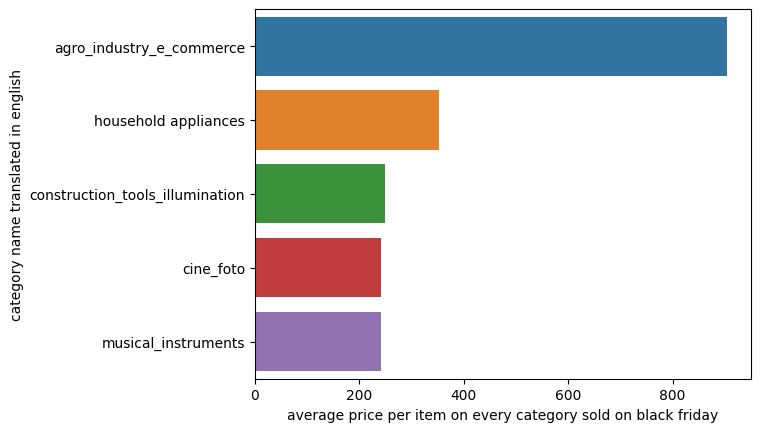

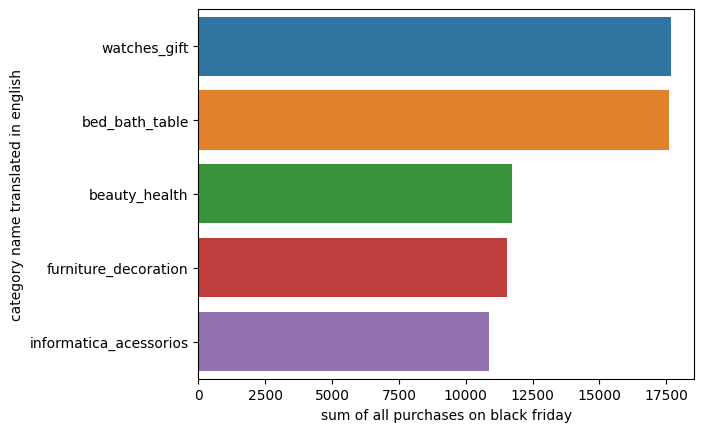

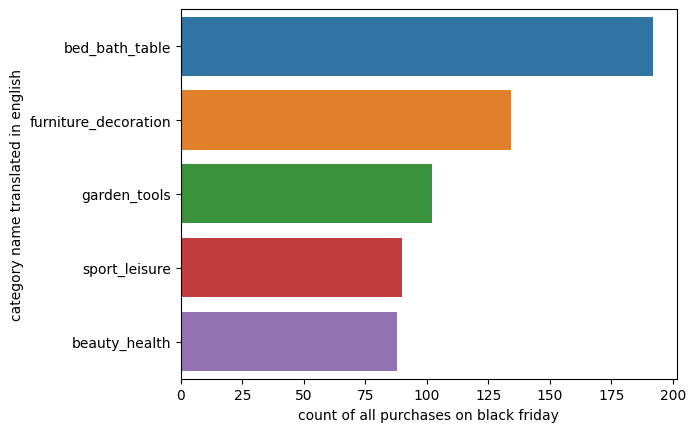

In [46]:

top_categories_to_show_on_plot = 5
for_plot_avg_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'avg_per_item'
    ]].sort_values('avg_per_item', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_avg_price['product_category_en'], x=for_plot_avg_price['avg_per_item'])
plt.xlabel('average price per item on every category sold on black friday')
plt.ylabel('category name translated in english')
plt.show()

for_plot_sum_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'prch_sum'
    ]].sort_values('prch_sum', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_sum_price['product_category_en'], x=for_plot_sum_price['prch_sum'])
plt.xlabel('sum of all purchases on black friday')
plt.ylabel('category name translated in english')
plt.show()

for_plot_count_price = df_black_friday_sales_agg[[
    'product_category_en', 
    'prch_count'
    ]].sort_values('prch_count', ascending=False).head(top_categories_to_show_on_plot)

sns.barplot(y=for_plot_count_price['product_category_en'], x=for_plot_count_price['prch_count'])
plt.xlabel('count of all purchases on black friday')
plt.ylabel('category name translated in english')
plt.show()

Now we just need to write an email where we will explain what we see on graphs.<br>

P.S. We can see, that we have two categories with the same names household appliances_2 and household appliances.<br>
We need to rename it in previous steps using lambda function, like<br>
df['eng_cat'] = df['eng_cat'].apply(lambda x: "household appliances" if x == "household appliances_2" else x)<br>
I just don't want to do it and want to left it like this for now... 

edit: I've just fixed it, everything is fine now

Next question from business is:<br>
Do some sellers increase their prices before black friday to have "fake discount"?<br>
That sellers should be banned from participating in next black friday events so we need to check this fact and get list of unscrupulous sellers.

To answer this question we need to track exact product id by the exact seller id. Because it is not prohibited to have prices higher all the time. It is only against the rules to increase prices before "black friday" campaign. Before we check how many products + sellers pairs do we have, we need to prepare our dataset a little bit. Like we need to have only purchases on Black friday and before it. We don't need information after Black Friday campaign

In [47]:
df_orders_plus_for_spark.order_purchase_date.value_counts().head(10)

2017-11-24    1345
2017-11-25     569
2017-11-27     469
2017-11-26     450
2017-11-28     427
2018-08-06     421
2018-05-15     419
2018-08-07     417
2018-05-07     409
2018-05-14     404
Name: order_purchase_date, dtype: int64

Sales were high untill 28th of November. Let's cut everything that is less than that

In [48]:
black_friday_and_before_sales = df_orders_plus_for_spark[df_orders_plus_for_spark['order_purchase_date'] <= '2017-11-28']
black_friday_and_before_sales.order_purchase_date.max()

'2017-11-28'

Also we need only products + sellers that have sold potentially high priced products only on this dates (2017-11-24 - 2017-11-28). We don't need to investigate price changes on products before our campaign.

In [49]:
black_friday_sales = black_friday_and_before_sales[black_friday_and_before_sales['order_purchase_date'] >= '2017-11-24']
print(black_friday_sales.order_purchase_date.min())
print(black_friday_sales.order_purchase_date.max())
black_friday_product_seller_pairs = black_friday_sales[["product_id", "seller_id"]].drop_duplicates().reset_index(drop=True)
black_friday_product_seller_pairs

2017-11-24
2017-11-28


,product_id,seller_id
0,cf5407ad3a5c603fa46d5c2613661a09,dd7ddc04e1b6c2c614352b383efe2d36
1,e1da6ab77f4859eb17950e5df1c0f815,dd7ddc04e1b6c2c614352b383efe2d36
2,672a21bf17c63f71edbe01ecb9b14814,dd7ddc04e1b6c2c614352b383efe2d36
3,9df852a6c839bc3202227666d70c7cae,dd7ddc04e1b6c2c614352b383efe2d36
4,d52463875db80535c279cf58f6f5c183,5b51032eddd242adc84c38acab88f23d
...,...,...
1892,be093c0e6f627542bae561c8f3dff875,20d53aad4fe5ee93a64f8839609d3586
1893,b35370362fa3ad4b1976f2a11f146dfd,78744a20ee2f80ba64f6804c25def2b8
1894,afacf402a384ac6715d297140b5a275c,84deb808079d1be601c209c1e771b1cc
1895,9749d8875e250b3cb65d938c46efac5a,cb4a705d00e100b9732d0ca34817d441


Great! Now let's check what product-seller pairs do we have

In [50]:
product_seller_pair = black_friday_and_before_sales[['product_id', 'seller_id', 'order_id']].groupby(['product_id', 'seller_id']).count().sort_values('order_id', ascending=False).reset_index()
product_seller_pair.columns = ['product_id', 'seller_id', 'count']
product_seller_pair

,product_id,seller_id,count
0,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,329
1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,221
2,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,200
3,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,185
4,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,176
...,...,...,...
15450,6ae4d45dedc378571b9c404275008674,5cf13accae3222c70a9cac40818ae839,1
15451,6af5a2183cea4408f4292dd86be5f667,e88c9b79e592e370d6bd852eeefbf057,1
15452,6af944d65385c537dd7fb26787c7dae3,d93844a9c55ba7ce353388bcf849ea56,1
15453,6afddd846da3dd77e807fb9af5930aae,855668e0971d4dfd7bef1b6a4133b41b,1


It is obvious, that we need to drop any product ID + seller id pairs that have only 1 order. We can't track price increase from only one purchase.

In [51]:
product_seller_pair = product_seller_pair[product_seller_pair['count'] > 1]
product_seller_pair

,product_id,seller_id,count
0,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,329
1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,221
2,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,200
3,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,185
4,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,176
...,...,...,...
6406,50a64d6b01398039142e3e0be6f2fca4,0d85bbda9889ce1f7e63778d24f346eb,2
6407,453b0d78c257bdb2b47099a6a1c22040,f5a590cf36251cf1162ea35bef76fe84,2
6408,d65f3ccead8c91ecca73fb775ee50cc8,d91fb3b7d041e83b64a00a3edfb37e4f,2
6409,5066fb9bf2b3db42c59f2f7732387249,59cd88080b93f3c18508673122d26169,2


Let's join this information to our preciously generated table with sales on black friday

In [52]:
black_friday_product_seller_pairs_with_stats = black_friday_product_seller_pairs.merge(product_seller_pair, how='inner', on=['product_id', 'seller_id'])
black_friday_product_seller_pairs_with_stats.sort_values('count', ascending=False)

,product_id,seller_id,count
28,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,329
64,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,221
21,154e7e31ebfa092203795c972e5804a6,cc419e0650a3c5ba77189a1882b7556a,200
60,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,185
61,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,176
...,...,...,...
419,f699b297070aa38aaf3de9639302506a,c3867b4666c7d76867627c2f7fb22e21,2
424,4fbe3ca0032bccfba232332f06ed4146,cca3071e3e9bb7d12640c9fbe2301306,2
431,fbf19c12a50f1467bcae50364475ca26,cca3071e3e9bb7d12640c9fbe2301306,2
873,8e5e831d742acedb1758e90e18974231,25cf099de44674fde97473224f9d59ab,2


Peachy :) <br>
Before continuing our analysis let's investigate first line by hands and look at prices

In [53]:
black_friday_and_before_sales[(black_friday_and_before_sales['product_id']=='99a4788cb24856965c36a24e339b6058') & (black_friday_and_before_sales['seller_id']=='4a3ca9315b744ce9f8e9374361493884')].price.value_counts()

89.9    329
Name: price, dtype: int64

Price remain the same on this one. Let's check if this picture is the same for other product_id	+ seller_id pairs and prices

In [54]:
product_id_seller_id_prices = black_friday_and_before_sales[['product_id', 'seller_id', 'price']].merge(black_friday_product_seller_pairs_with_stats[['product_id', 'seller_id']], on=['product_id', 'seller_id']).drop_duplicates()
product_id_seller_id_prices.columns = ['product_id', 'seller_id', 'price']
product_id_seller_id_prices

,product_id,seller_id,price
0,cf5407ad3a5c603fa46d5c2613661a09,dd7ddc04e1b6c2c614352b383efe2d36,29.90
5,e1da6ab77f4859eb17950e5df1c0f815,dd7ddc04e1b6c2c614352b383efe2d36,45.90
12,9df852a6c839bc3202227666d70c7cae,dd7ddc04e1b6c2c614352b383efe2d36,39.99
13,9df852a6c839bc3202227666d70c7cae,dd7ddc04e1b6c2c614352b383efe2d36,38.99
14,7c4a8bec217df1de0df2b5aaf8175b65,7040e82f899a04d1b434b795a43b4617,19.90
...,...,...,...
11238,34eb6a7adb729aa877c2eeccf886f09f,2a50b7ee5aebecc6fd0ff9784a4747d6,99.90
11240,edaf40b482ce18cabb1e1c00c4cfa2d1,a9b533a26e898b12e8b8d4c07279bf4d,29.90
11243,00bb62ea3729537a687c3fddcd123662,1fe61aa5494bd3ae92a2c13e067c810f,268.88
11245,b35370362fa3ad4b1976f2a11f146dfd,78744a20ee2f80ba64f6804c25def2b8,499.00


In [55]:
count_product_id_seller_id_prices = product_id_seller_id_prices.groupby(['product_id', 'seller_id']).count()
count_product_id_seller_id_prices.value_counts(normalize=True)

price
1        0.607517
2        0.284965
3        0.072552
4        0.017483
6        0.007867
5        0.005245
7        0.002622
8        0.000874
12       0.000874
dtype: float64

It seems that 60% of the goods remained with the same prices. Let's drop them from our analysis

In [56]:
more_than_one_count_product_id_seller_id_prices = count_product_id_seller_id_prices[count_product_id_seller_id_prices['price'] > 1].reset_index()
more_than_one_count_product_id_seller_id_prices

,product_id,seller_id,price
0,007c63ae4b346920756b5adcad8095de,53e4c6e0f4312d4d2107a8c9cddf45cd,3
1,00d2add85b1f5aba6bb3d5d977314e25,37dd29b36c458d82f74a953c40c43645,2
2,02ce467092b184e71d3967d29110adc1,7c67e1448b00f6e969d365cea6b010ab,2
3,036734b5a58d5d4f46b0616ddc047ced,ea8482cd71df3c1969d7b9473ff13abc,2
4,03bb06cda40712fb8473f7962fb7d198,da8622b14eb17ae2831f4ac5b9dab84a,3
...,...,...,...
444,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,4
445,fe75529a267b76ac6e96f0c322a899a4,620c87c171fb2a6dd6e8bb4dec959fc6,2
446,ff7c7524d5f9a8386ab27088ec03c1fb,259f7b5e6e482c230e5bfaa670b6bb8f,2
447,ffae6024df16802ba75f761d9aa24367,7040e82f899a04d1b434b795a43b4617,2


To finish our analysis let's create two datasets for this product_id seller_id pairs. One with max prices on "Black Friday" campaign dates and another with min prices on "before Black Friday" interval

In [57]:
black_friday_and_before_sales

,order_id,product_id,seller_id,price,order_status,order_purchase_timestamp,product_category_name,seller_city,seller_state,eng_category,order_purchase_date,order_purchase_time
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-09-13 08:59:02,cool_stuff,volta redonda,SP,cool_stuff,2017-09-13,08:59:02
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,delivered,2017-06-28 11:52:20,cool_stuff,volta redonda,SP,cool_stuff,2017-06-28,11:52:20
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-01 18:38:42,cool_stuff,volta redonda,SP,cool_stuff,2017-08-01,18:38:42
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,delivered,2017-08-10 21:48:40,cool_stuff,volta redonda,SP,cool_stuff,2017-08-10,21:48:40
5,a0f9acf0b6294ed8561e32cde1a966bc,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,delivered,2017-07-27 15:11:51,cool_stuff,volta redonda,SP,cool_stuff,2017-07-27,15:11:51
...,...,...,...,...,...,...,...,...,...,...,...,...
112631,f9c44da06151c190a9a6c9c712873d10,b864b103180d5a6a3f830e67f93e8735,f5b84683a9bf9e1df748cf40f601b39c,83.9,delivered,2016-10-08 22:11:57,bebes,sao paulo,SP,babies,2016-10-08,22:11:57
112634,fbff77db5421bb7e1da292db45d07e75,654ccc4e5459e7ba6b8d9fb04c45b9db,2d8cfba3fcd3170555941605edaa196a,45.0,delivered,2017-03-15 11:41:46,livros_tecnicos,osasco,SP,technical_books,2017-03-15,11:41:46
112641,fcb25cc2887d15b5373673a0630ad13a,47ac3d02c68a76bc97b3b305f6e1192f,749e7cdabbaf72f16677859e27874ba5,41.9,delivered,2017-09-03 17:20:56,unknown_category,guarulhos,SP,unknown_category,2017-09-03,17:20:56
112645,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,119.9,delivered,2017-04-19 10:20:51,moveis_decoracao,curitiba,PR,furniture_decoration,2017-04-19,10:20:51


In [58]:
only_pairs_that_we_want_all_interval = black_friday_and_before_sales.merge(more_than_one_count_product_id_seller_id_prices[['product_id', 'seller_id']], on=['product_id', 'seller_id'])
only_pairs_that_we_want_all_interval.shape

(6782, 12)

In [59]:
only_pairs_that_we_want_before_interval = only_pairs_that_we_want_all_interval[only_pairs_that_we_want_all_interval['order_purchase_date'] < '2017-11-24']
only_pairs_that_we_want_bf_interval = only_pairs_that_we_want_all_interval[only_pairs_that_we_want_all_interval['order_purchase_date'] >= '2017-11-24']

In [60]:
min_price_and_date_before_bf_df = only_pairs_that_we_want_before_interval[['product_id', 'seller_id', 'price', 'order_purchase_date']]
rank = min_price_and_date_before_bf_df.groupby(['product_id', 'seller_id'])['price'].rank('first')
min_price_and_date_before_bf_df = min_price_and_date_before_bf_df[rank == 1]
min_price_and_date_before_bf_df.columns = ['product_id', 'seller_id', 'min_price_before_bf', 'date_min_price']
min_price_and_date_before_bf_df

,product_id,seller_id,min_price_before_bf,date_min_price
1,9df852a6c839bc3202227666d70c7cae,dd7ddc04e1b6c2c614352b383efe2d36,38.99,2017-05-10
11,7c4a8bec217df1de0df2b5aaf8175b65,7040e82f899a04d1b434b795a43b4617,15.90,2017-10-06
21,53090d94b00b6613c77382b7f4617d2b,7040e82f899a04d1b434b795a43b4617,22.90,2017-11-17
23,657491063e8a63247a108a4d9cedf020,7040e82f899a04d1b434b795a43b4617,99.90,2017-11-12
24,ffae6024df16802ba75f761d9aa24367,7040e82f899a04d1b434b795a43b4617,19.90,2017-09-27
...,...,...,...,...
6759,dc68ee0fcb033a1ab6714fbb5db60c15,02d35243ea2e497335cd0f076b45675d,249.00,2017-08-21
6774,7775d718fa8dfebe8015e6e5ee3dc5be,c24173065483e421f9e5e7f599de101d,35.99,2017-07-27
6776,00d2add85b1f5aba6bb3d5d977314e25,37dd29b36c458d82f74a953c40c43645,346.32,2017-10-21
6778,b71e22caa2e31ed1309fd01850d79ea4,954e95f20808d7e5d11f0de292d078e0,32.99,2017-09-17


In [61]:
max_price_bf_df = only_pairs_that_we_want_bf_interval[['product_id', 'seller_id', 'price']].groupby(['product_id', 'seller_id']).max().reset_index()
max_price_bf_df.columns = ['product_id', 'seller_id', 'max_price_bf']
max_price_bf_df

,product_id,seller_id,max_price_bf
0,007c63ae4b346920756b5adcad8095de,53e4c6e0f4312d4d2107a8c9cddf45cd,71.00
1,00d2add85b1f5aba6bb3d5d977314e25,37dd29b36c458d82f74a953c40c43645,355.79
2,02ce467092b184e71d3967d29110adc1,7c67e1448b00f6e969d365cea6b010ab,169.99
3,036734b5a58d5d4f46b0616ddc047ced,ea8482cd71df3c1969d7b9473ff13abc,29.99
4,03bb06cda40712fb8473f7962fb7d198,da8622b14eb17ae2831f4ac5b9dab84a,144.90
...,...,...,...
444,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,700.90
445,fe75529a267b76ac6e96f0c322a899a4,620c87c171fb2a6dd6e8bb4dec959fc6,82.90
446,ff7c7524d5f9a8386ab27088ec03c1fb,259f7b5e6e482c230e5bfaa670b6bb8f,35.90
447,ffae6024df16802ba75f761d9aa24367,7040e82f899a04d1b434b795a43b4617,14.90


In [62]:
question_2_df = pd.merge(max_price_bf_df, min_price_and_date_before_bf_df, on=['product_id', 'seller_id'])
question_2_df['date_min_price'] = pd.to_datetime(question_2_df['date_min_price'])

question_2_df['price_dif_ok'] = question_2_df['max_price_bf'] <= question_2_df['min_price_before_bf']
question_2_df['days_till_bf'] = question_2_df['date_min_price'].apply(lambda x: (pd.to_datetime('2017-11-24') - x).days)

question_2_df['price_diff_percent'] = ((question_2_df['max_price_bf'] / question_2_df['min_price_before_bf']) - 1) * 100
question_2_df['price_diff_percent'] = question_2_df['price_diff_percent'].apply(lambda x: 0 if x <= 0 else x)


question_2_df

,product_id,seller_id,max_price_bf,min_price_before_bf,date_min_price,price_dif_ok,days_till_bf,price_diff_percent
0,007c63ae4b346920756b5adcad8095de,53e4c6e0f4312d4d2107a8c9cddf45cd,71.00,72.99,2017-03-05,True,264,0.000000
1,00d2add85b1f5aba6bb3d5d977314e25,37dd29b36c458d82f74a953c40c43645,355.79,346.32,2017-10-21,False,34,2.734465
2,02ce467092b184e71d3967d29110adc1,7c67e1448b00f6e969d365cea6b010ab,169.99,169.99,2017-08-29,True,87,0.000000
3,036734b5a58d5d4f46b0616ddc047ced,ea8482cd71df3c1969d7b9473ff13abc,29.99,27.99,2017-10-13,False,42,7.145409
4,03bb06cda40712fb8473f7962fb7d198,da8622b14eb17ae2831f4ac5b9dab84a,144.90,129.90,2017-02-06,False,291,11.547344
...,...,...,...,...,...,...,...,...
443,fe59a1e006df3ac42bf0ceb876d70969,25c5c91f63607446a97b143d2d535d31,700.90,700.90,2017-11-21,True,3,0.000000
444,fe75529a267b76ac6e96f0c322a899a4,620c87c171fb2a6dd6e8bb4dec959fc6,82.90,82.90,2017-11-15,True,9,0.000000
445,ff7c7524d5f9a8386ab27088ec03c1fb,259f7b5e6e482c230e5bfaa670b6bb8f,35.90,35.90,2017-08-03,True,113,0.000000
446,ffae6024df16802ba75f761d9aa24367,7040e82f899a04d1b434b795a43b4617,14.90,19.90,2017-09-27,True,58,0.000000


Great! That is what we want. price_dif_ok column indicates if "black friday" price is lower than "before black friday" price. And the days_till_bf column indicates on how many days before black friday product had this price (may be it was a local discount like "Samsung products 20% discount!" or something like that). Also price_diff_percent column indicates for how many percents min price before black friday is lower than max price during black friday. Notice that if black friday price is lower this column will indicate show 0% because we are not interested in this cases.

In [69]:
question_2_df.price_dif_ok.value_counts()

False    227
True     221
Name: price_dif_ok, dtype: int64

We have got really interesting results. It seems like 50% of seller_id + product_id pairs had a real discount during black friday and 50% cheated. Let's prepare final table that we will send to our business to investigate.

In [73]:
# only pairs with high black friday prices
send_this_table = question_2_df[question_2_df['price_dif_ok'] == False].copy()
# in real case scenario I would join phone numbers or some information to this table on "seller_id"
# then I would save this file to excel, rename some columns for business and send it via email with information on how I made my analysis
# also business can filter out some price difference that are not so significant (look at the last line where price dropped for 1cent)
send_this_table.sort_values('price_diff_percent', ascending=False)

,product_id,seller_id,max_price_bf,min_price_before_bf,date_min_price,price_dif_ok,days_till_bf,price_diff_percent
34,20518c6950587eb5e8f02dad2fa0d685,aae3bfea055532c57fb453ed3ec80b30,180.00,77.08,2017-02-20,False,277,133.523612
220,82c3ea364e5480f335f6743ee725a921,70a12e78e608ac31179aea7f8422044b,49.00,25.00,2017-08-18,False,98,96.000000
336,c7b3cf9de7be95b3e09e7a63315685eb,5dceca129747e92ff8ef7a997dc4f8ca,99.90,59.90,2017-03-08,False,261,66.777963
424,f5caa36f71f444c6508c84818cab5641,dd533b429f380718b70ad9922c294bae,31.90,19.90,2017-09-05,False,80,60.301508
368,d75fe2da6eb275eafad5535fff7a2005,014c0679dd340a0e338872e7ec85666a,175.00,110.00,2017-01-26,False,302,59.090909
...,...,...,...,...,...,...,...,...
237,8c591ab0ca519558779df02023177f44,a1043bafd471dff536d0c462352beb48,89.99,89.00,2017-10-20,False,35,1.112360
218,823d744bdaf063ad824cac2fc3540fd8,02ecc2a19303f05e59ce133fd923fff7,238.90,238.10,2017-11-01,False,23,0.335993
377,dc404a1496a08f9f5540c8b5d4b92925,46dc3b2cc0980fb8ec44634e21d2718e,299.99,299.00,2017-10-18,False,37,0.331104
389,e3dd336775af78a83fc27ed85f0f15da,edb1ef5e36e0c8cd84eb3c9b003e486d,395.65,395.00,2017-09-28,False,57,0.164557


#### Next question
What categories of products were sold the most by state and city - we need to be sure that we have enough goods for our customers <br>
Here we just need to group by state and city. This is kinda simple

In [96]:
import datetime

question_3_df = df_orders_plus[
    (df_orders_plus['order_purchase_date']>=datetime.date(2017, 11, 24)) & (df_orders_plus['order_purchase_date']<=datetime.date(2017, 11, 28))
    ][['order_id', 'eng_category', 'seller_city', 'seller_state', 'order_purchase_date']].copy()

print(question_3_df['order_purchase_date'].value_counts(), '\n' + ('-'*40))
question_3_df.drop(columns=['order_purchase_date'], inplace=True)

question_3_df = question_3_df.groupby(['seller_state', 'seller_city', 'eng_category']).count()
question_3_df.columns = ['count_products_sold']
question_3_df

2017-11-24    1345
2017-11-25     569
2017-11-27     469
2017-11-26     450
2017-11-28     427
Name: order_purchase_date, dtype: int64 
----------------------------------------


count_products_sold
seller_state seller_city          eng_category                              
BA           feira de santana     watches_gift                             1
             lauro de freitas     telephony                               29
             salvador             food_drinks                              6
CE           pacatuba             furniture_living room                    1
DF           brasilia             Audio                                    1
...                                                                      ...
SP           vargem grande do sul Automotive                               1
             vicente de carvalho  drinks                                   2
                                  sport_leisure                            4
             votorantim           bed_bath_table                           5
             votuporanga          sport_leisure                            3

[582 rows x 1 columns]

In [97]:
question_3_df.reset_index().sort_values('count_products_sold', ascending=False)

,seller_state,seller_city,eng_category,count_products_sold
341,SP,ibitinga,bed_bath_table,256
515,SP,sao jose do rio preto,garden_tools,199
543,SP,sao paulo,furniture_decoration,153
554,SP,sao paulo,telephony,103
482,SP,santo andre,beauty_health,63
...,...,...,...,...
252,SC,videira,Stationery,1
249,SC,timbo,fashion_clothing_men,1
248,SC,timbo,fashion_bags_and_accessories,1
245,SC,sao jose,Automotive,1


Basicaly this is the answer for question 3. This table will give business an undestanding of what categories in what cities should be covered with extra attention

Let's create a plot (just for educational purpuses) that will whow top 10 catecories as a pie chart and other categories would be in "others" section (as part of top 10)

In [140]:
for_plot = question_3_df.reset_index()[['eng_category', 'count_products_sold']].groupby('eng_category').sum()

overall_prch_cnt = for_plot.count_products_sold.sum()
for_plot = for_plot.sort_values('count_products_sold',ascending=False).head(9)
for_plot.loc['others'] = overall_prch_cnt - for_plot.sum()
for_plot['count_products_sold_prc'] = np.round((for_plot['count_products_sold'] / overall_prch_cnt) * 100, 2)
print('this must be 100% - ', for_plot['count_products_sold_prc'].sum())
for_plot = for_plot.reset_index()
for_plot

this must be 100% -  100.0


,eng_category,count_products_sold,count_products_sold_prc
0,bed_bath_table,424,13.01
1,furniture_decoration,323,9.91
2,garden_tools,252,7.73
3,sport_leisure,223,6.84
4,beauty_health,221,6.78
5,toys,206,6.32
6,informatica_acessorios,198,6.07
7,telephony,163,5.00
8,domestic_utilities,151,4.63
9,others,1099,33.71


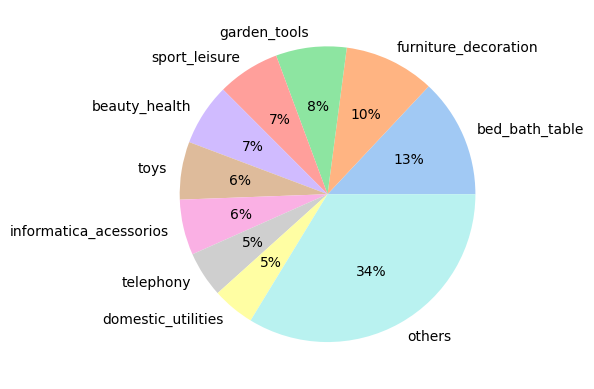

In [141]:
data = for_plot.count_products_sold_prc
labels = for_plot.eng_category
colors = sns.color_palette('pastel')[0:data.shape[0]]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

We answered for all the questions. Let's move on and create an app from this jupyter notebook. I will use "app" folder in the root of this git directory

In [ ]:
c = translation_dict = de_serialize(cached_path)
c

{'cool_stuff': 'cool_stuff',
 'pet_shop': 'pet_shop',
 'moveis_decoracao': 'furniture_decoration',
 'perfumaria': 'perfumery',
 'ferramentas_jardim': 'garden_tools',
 'utilidades_domesticas': 'domestic_utilities',
 'telefonia': 'telephony',
 'beleza_saude': 'beauty_health',
 'livros_tecnicos': 'technical_books',
 'fashion_bolsas_e_acessorios': 'fashion_bags_and_accessories',
 'cama_mesa_banho': 'bed_bath_table',
 'esporte_lazer': 'sport_leisure',
 'consoles_games': 'consoles_games',
 'moveis_escritorio': 'office_furniture',
 'malas_acessorios': 'suitcases_accessories',
 'alimentos': 'food',
 'agro_industria_e_comercio': 'agro_industry_e_commerce',
 'eletronicos': 'electronic',
 'informatica_acessorios': 'informatica_acessorios',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'audio': 'Audio',
 'bebes': 'babies',
 'construcao_ferramentas_iluminacao': 'construction_tools_illumination',
 'brinquedos': 'toys',
 'papelaria': 'Stationery',
 'industria_comercio_e_ne

In [ ]:
os.path.isfile(cached_path)

True